# Get the data and imports

In [1]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

File 'airline_passengers.csv' already there; not retrieving.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
# Check if there are any nan values
df.isna().sum()

Passengers    0
dtype: int64

<Axes: xlabel='Month'>

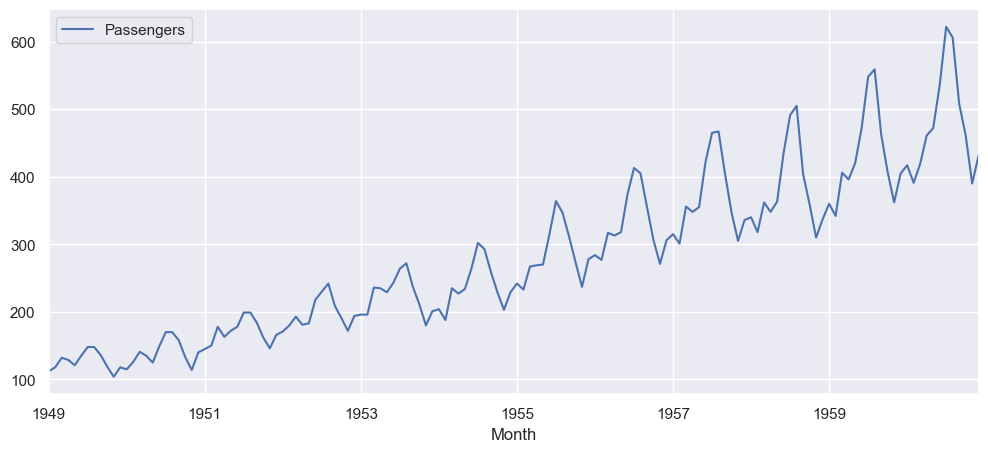

In [5]:
# Plot the data to see the trend
df.plot(figsize=(12, 5))

Can observe both a trend and a cyclcical component.

# Calculate the EWMA

<Axes: xlabel='Month'>

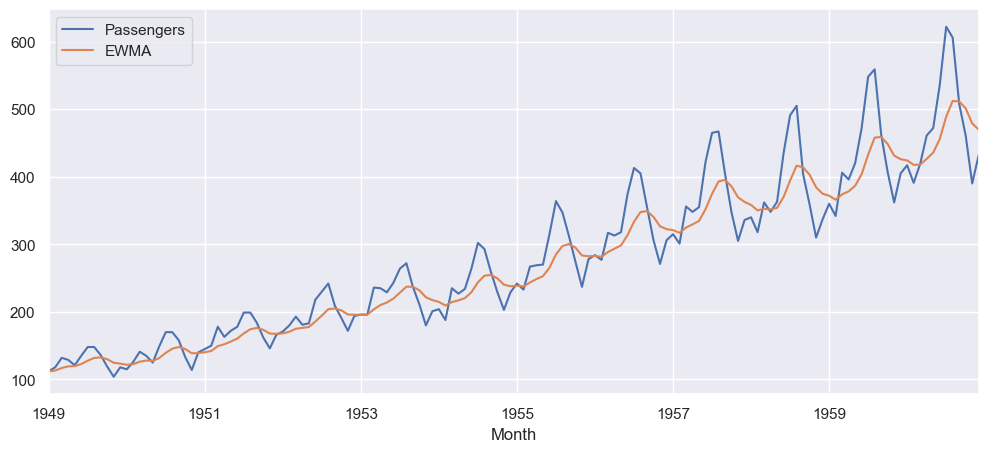

In [6]:
alpha = 0.2
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean() # adjust=False means that we are using the formula for the EWMA
df.plot(figsize=(12, 5))

# Simple Exponenntial Smoothing Forecasting

In [7]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [8]:
df.head()

,Passengers,EWMA
Month,,
1949-01-01,112,112.0000
1949-02-01,118,113.2000
1949-03-01,132,116.9600
1949-04-01,129,119.3680
1949-05-01,121,119.6944


In [10]:
# Assign frequency to the data
df.index.freq = 'MS' # MS means Monthly Start (the first day of the month) - this is the default frequency for pandas
df.head()

,Passengers,EWMA
Month,,
1949-01-01,112,112.0000
1949-02-01,118,113.2000
1949-03-01,132,116.9600
1949-04-01,129,119.3680
1949-05-01,121,119.6944


In [11]:
# Create the model and fit it to the data (the data is the passengers column) 
ses = SimpleExpSmoothing(df['Passengers'])

In [12]:
alpha = 0.2
results = ses.fit(smoothing_level=alpha, optimized=False) # optimized=False means that we are using the formula for the EWMA

In [14]:
df['SES'] = results.predict(start=df.index[0], end=df.index[-1]) # predict the values for the whole in-sample data

In [16]:
np.allclose(df['SES'], results.fittedvalues) # check if the predicted values are the same as the fitted values

True

<Axes: xlabel='Month'>

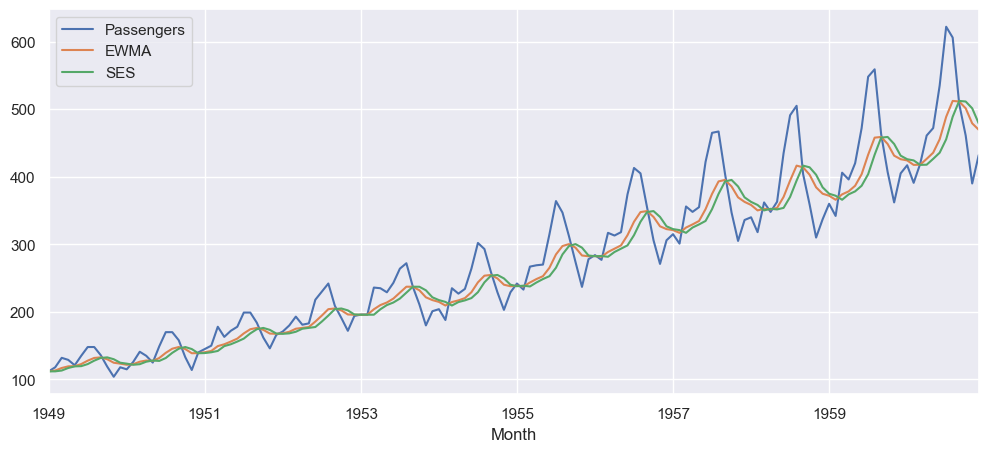

In [17]:
# plot the data
df.plot(figsize=(12, 5))

We notice that the SES and EWMA results are differnet. This is because SES repeates the first value. This happens as the forecasting model is defined slightly differently from EWMA. The forecasting time index is moved up by one step. The EWMA is repressented by the l-level, while the prediction y_hat is assigned the level at the previous timestep. 

In [18]:
df.head()

,Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [22]:
# Carry out a train-test split with 12 data points and forecasting 
N_test = 12
train = df.iloc[:len(df)-N_test]
test = df.iloc[len(df)-N_test:]

In [23]:
ses = SimpleExpSmoothing(train['Passengers'])
results = ses.fit() # not passing in alpha because we want the model to optimize it for us

<Axes: xlabel='Month'>

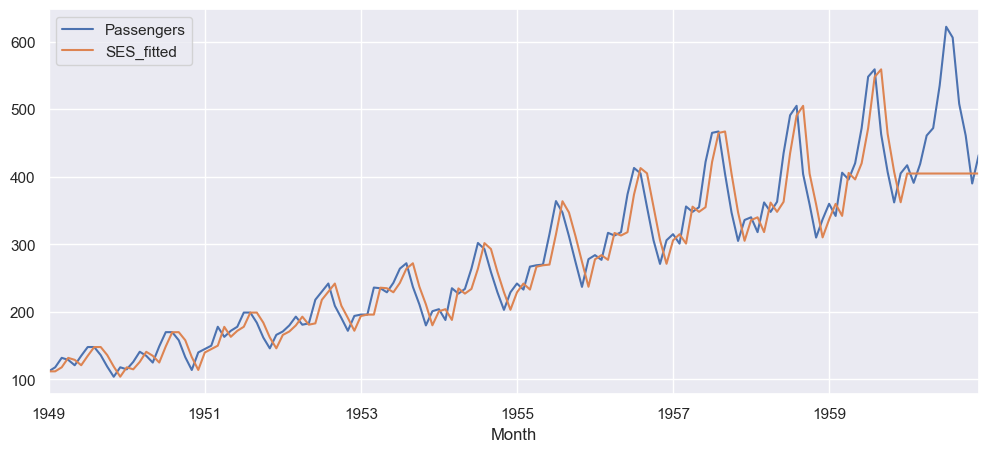

In [24]:
# Assign the predictions back to the model

train_index = df.index <= train.index[-1]
test_index = df.index > train.index[-1]

df.loc[train_index, 'SES_fitted'] = results.fittedvalues
df.loc[test_index, 'SES_fitted'] = results.forecast(N_test)

df[['Passengers', 'SES_fitted']].plot(figsize=(12, 5))

In [25]:
# Let's check the alpha
results.model.params['smoothing_level']

0.995

In [27]:
# Check all the parameters
results.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}